***Extracción***

In [5]:
import pandas as pd
import json
import requests

# URL del JSON
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'

# Cargar datos
response = requests.get(url)
data = response.json()

# Crear DataFrame inicial
df = pd.DataFrame(data)

# Expandir columnas con diccionarios
dict_cols = ['customer', 'phone', 'internet', 'account']
for col in dict_cols:
    dict_df = pd.json_normalize(df[col])
    dict_df.columns = [f"{col}.{subcol}" for subcol in dict_df.columns]
    df = pd.concat([df.drop(columns=[col]), dict_df], axis=1)

# Verificamos el resultado
print(df.head())
print(df.dtypes)


   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet.InternetService  ... 

Consideraciones preliminares:
Para este análisis tendré en cuenta los siguientes conjuntos de datos:
Tenure (antiguedad de los clientes): Refleja no solo cuántos años ha estado el cliente en contrato con la empresa, sino también es un valor importante a la hora de saber el por qué de la deserción de los mismos, ¿Ha sido pronto?¿Ha sido luego de varios años de servicio?¿Por qué?
monthly_charges(pago por mes): Este dato es muy importante a la hora del análisis, nos dirá cuánto paga cada cliente y nos aportará información de cuánto influye el costo del servicio en su desición de abandonar el servicio.
total_charges(pagos totales): Al igual que la categoría anterior nos ayudará a enteder cuánto influyen las finanzas en las desiciones de los clientes.
contrac_type (tipo de contrato: anual, mensual, etc.): Nos ayudará a entender cuáles clientes desertan con frecuencia, si hay una tendencia marcada o no, y qué tan influyente es el tipo de contrato que cada uno tiene.
internet_service_type(tipo de servicio de internet contratado): Nos brinda información sobre las contrataciones.
payment_method(forma de pago): Nos dirá que prefieren los clientes.


**Transformación**

In [6]:
#Valores Nulos:
df.isnull().sum()

,0
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [7]:
#Valores duplicados:
df.duplicated().sum()

np.int64(0)

In [8]:
#Revisión de tipo de datos:
df.dtypes

,0
customerID,object
Churn,object
customer.gender,object
customer.SeniorCitizen,int64
customer.Partner,object
customer.Dependents,object
customer.tenure,int64
phone.PhoneService,object
phone.MultipleLines,object
internet.InternetService,object


In [9]:
#Corregir los datos y eliminar nulos:
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')
df['account.Charges.Total'].isnull().sum()
df = df.dropna(subset=['account.Charges.Total'])

In [10]:
#Explorando la columna Chruns:
df['Churn'].value_counts()
#Noté que había 224 datos que no correspondían con el análisis.
df.loc[~df['Churn'].isin(['Yes', 'No']), 'Churn'].unique()
#A partir de este código entendí que eran caracteres vacíos pero no nulos, asi que decidí eliminar esos 224 datos.
df = df[df['Churn'].isin(['Yes', 'No'])]
df['Churn'].value_counts()
#Para un mejor análisis convertí las columnas de "No" y "Yes" a valores binarios 0 y 1 respectivamente:
df['Churn_binary'] = df['Churn'].map({'No': 0, 'Yes': 1})
df['Churn_binary'].value_counts()

,count
Churn_binary,
0,5163
1,1869


In [11]:
#Limpieza de variables categóricas:
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\nValores únicos en '{col}':")
    print(df[col].unique())

# Diccionario de mapeo
yes_no_map = {'Yes': 1, 'No': 0}

# Aplicamos el mapeo
df['Churn'] = df['Churn'].map(yes_no_map)
df['customer.gender'] = df['customer.gender'].map({'Female': 1, 'Male': 0})
df['customer.Partner'] = df['customer.Partner'].map(yes_no_map)
df['customer.Dependents'] = df['customer.Dependents'].map(yes_no_map)
df['phone.PhoneService'] = df['phone.PhoneService'].map(yes_no_map)
df['account.PaperlessBilling'] = df['account.PaperlessBilling'].map(yes_no_map)


Valores únicos en 'customerID':
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

Valores únicos en 'Churn':
['No' 'Yes']

Valores únicos en 'customer.gender':
['Female' 'Male']

Valores únicos en 'customer.Partner':
['Yes' 'No']

Valores únicos en 'customer.Dependents':
['Yes' 'No']

Valores únicos en 'phone.PhoneService':
['Yes' 'No']

Valores únicos en 'phone.MultipleLines':
['No' 'Yes' 'No phone service']

Valores únicos en 'internet.InternetService':
['DSL' 'Fiber optic' 'No']

Valores únicos en 'internet.OnlineSecurity':
['No' 'Yes' 'No internet service']

Valores únicos en 'internet.OnlineBackup':
['Yes' 'No' 'No internet service']

Valores únicos en 'internet.DeviceProtection':
['No' 'Yes' 'No internet service']

Valores únicos en 'internet.TechSupport':
['Yes' 'No' 'No internet service']

Valores únicos en 'internet.StreamingTV':
['Yes' 'No' 'No internet service']

Valores únicos en 'internet.StreamingMovies':
['No' 'Yes' 'No internet servi

In [12]:
#Separar variables dependientes e independientes:
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

In [13]:
#Crear la columna de cuentas diarias:
df['Cuentas_Diarias'] = df['account.Charges.Monthly'] / 30
#Verificación:
df[['account.Charges.Monthly', 'Cuentas_Diarias']].head()

,account.Charges.Monthly,Cuentas_Diarias
0,65.6,2.186667
1,59.9,1.996667
2,73.9,2.463333
3,98.0,3.266667
4,83.9,2.796667


In [14]:
#Estandarización y Transformación de los datos:
# Diccionario con los nuevos nombres
nuevos_nombres = {
    'customerID': 'ID_Cliente',
    'Churn': 'Evasion',
    'customer.gender': 'Genero',
    'customer.SeniorCitizen': 'Adulto_Mayor',
    'customer.Partner': 'Pareja',
    'customer.Dependents': 'Dependientes',
    'customer.tenure': 'Meses_Contrato',
    'phone.PhoneService': 'Servicio_Telefono',
    'phone.MultipleLines': 'Lineas_Multiples',
    'internet.InternetService': 'Servicio_Internet',
    'internet.OnlineSecurity': 'Seguridad_Online',
    'internet.OnlineBackup': 'Backup_Online',
    'internet.DeviceProtection': 'Proteccion_Dispositivo',
    'internet.TechSupport': 'Soporte_Tecnico',
    'internet.StreamingTV': 'Streaming_TV',
    'internet.StreamingMovies': 'Streaming_Peliculas',
    'account.Contract': 'Tipo_Contrato',
    'account.PaperlessBilling': 'Factura_Sin_Papel',
    'account.PaymentMethod': 'Metodo_Pago',
    'account.Charges.Monthly': 'Cobro_Mensual',
    'account.Charges.Total': 'Cobro_Total',
    'Cuentas_Diarias': 'Cobro_Diario',
    'Churn_binary': 'Evasion_Binaria'
}

# Aplicar renombrado
df.rename(columns=nuevos_nombres, inplace=True)

df.head()

,ID_Cliente,Evasion,Genero,Adulto_Mayor,Pareja,Dependientes,Meses_Contrato,Servicio_Telefono,Lineas_Multiples,Servicio_Internet,...,Soporte_Tecnico,Streaming_TV,Streaming_Peliculas,Tipo_Contrato,Factura_Sin_Papel,Metodo_Pago,Cobro_Mensual,Cobro_Total,Evasion_Binaria,Cobro_Diario
0,0002-ORFBO,0,1,0,1,1,9,1,No,DSL,...,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,0,2.186667
1,0003-MKNFE,0,0,0,0,0,9,1,Yes,DSL,...,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,0,1.996667
2,0004-TLHLJ,1,0,0,0,0,4,1,No,Fiber optic,...,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,1,2.463333
3,0011-IGKFF,1,0,1,1,0,13,1,No,Fiber optic,...,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,1,3.266667
4,0013-EXCHZ,1,1,1,1,0,3,1,No,Fiber optic,...,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,1,2.796667


In [15]:
# Encontrar columnas con 'Yes'/'No' aún presentes
cols_yes_no = [col for col in df.columns if df[col].dropna().isin(['Yes', 'No']).all()]

print(cols_yes_no)

yes_no_map = {'Yes': 1, 'No': 0}

for col in cols_yes_no:
    df[col] = df[col].map(yes_no_map)

[]


**Análisis Descriptivo**

In [16]:
df.describe()

,Evasion,Genero,Adulto_Mayor,Pareja,Dependientes,Meses_Contrato,Servicio_Telefono,Factura_Sin_Papel,Cobro_Mensual,Cobro_Total,Evasion_Binaria,Cobro_Diario
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,0.495307,0.162400,0.482509,0.298493,32.421786,0.903299,0.592719,64.798208,2283.300441,0.265785,2.159940
std,0.441782,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.491363,30.085974,2266.771362,0.441782,1.002866
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.608333
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.587500,401.450000,0.000000,1.186250
50%,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,0.000000,2.345000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.862500,3794.737500,1.000000,2.995417
max,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,3.958333


In [17]:
cols_num = ['Meses_Contrato', 'Cobro_Mensual', 'Cobro_Total', 'Cobro_Diario']

for col in cols_num:
    print(f"\nAnálisis de la columna '{col}':")
    print(f"Media: {df[col].mean():.2f}")
    print(f"Mediana: {df[col].median():.2f}")
    print(f"Desviación estándar: {df[col].std():.2f}")
    print(f"Valor mínimo: {df[col].min():.2f}")
    print(f"Valor máximo: {df[col].max():.2f}")


Análisis de la columna 'Meses_Contrato':
Media: 32.42
Mediana: 29.00
Desviación estándar: 24.55
Valor mínimo: 1.00
Valor máximo: 72.00

Análisis de la columna 'Cobro_Mensual':
Media: 64.80
Mediana: 70.35
Desviación estándar: 30.09
Valor mínimo: 18.25
Valor máximo: 118.75

Análisis de la columna 'Cobro_Total':
Media: 2283.30
Mediana: 1397.47
Desviación estándar: 2266.77
Valor mínimo: 18.80
Valor máximo: 8684.80

Análisis de la columna 'Cobro_Diario':
Media: 2.16
Mediana: 2.34
Desviación estándar: 1.00
Valor mínimo: 0.61
Valor máximo: 3.96


In [18]:
print("\nDistribución de Género:")
print(df['Genero'].value_counts())

print("\nDistribución de Evasión (Churn):")
print(df['Evasion'].value_counts())


Distribución de Género:
Genero
0    3549
1    3483
Name: count, dtype: int64

Distribución de Evasión (Churn):
Evasion
0    5163
1    1869
Name: count, dtype: int64


Interpretaciones preliminares:
La mediana de meses de contrato es menor que la media, indicando una cola larga de clientes con contratos largos.

El cobro mensual y total tienen alta variabilidad, quizás por diferentes planes y servicios contratados.

La tasa de evasión del ~26.5% es significativa para investigar qué características están asociadas a ella.

La distribución de género está equilibrada, por lo que el género no parece ser un factor desbalanceado en la muestra.

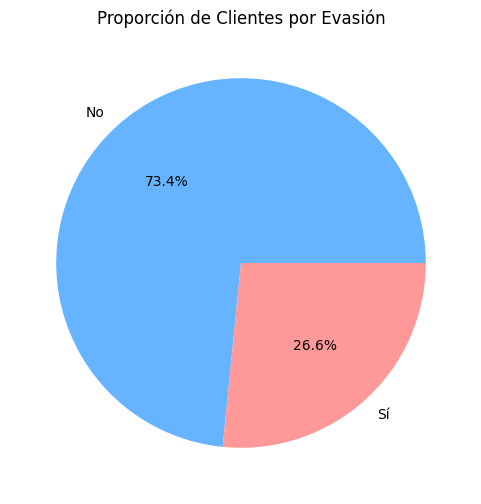

In [19]:
#Gráficos de evasión:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar valores de evasión
churn_counts = df['Evasion'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(churn_counts.values, labels=['No', 'Sí'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Proporción de Clientes por Evasión')
plt.show()

In [20]:
#Análisis de variables categóricas y evasión:
variables_categoricas = ['Genero', 'Tipo_Contrato', 'Metodo_Pago', 'Pareja', 'Dependientes']

for var in variables_categoricas:
    print(f"\nTasa de evasión por {var}:")
    tasa_evasion = df.groupby(var)['Evasion'].mean() * 100
    print(tasa_evasion.round(2).astype(str) + '%')



Tasa de evasión por Genero:
Genero
0     26.2%
1    26.96%
Name: Evasion, dtype: object

Tasa de evasión por Tipo_Contrato:
Tipo_Contrato
Month-to-month    42.71%
One year          11.28%
Two year           2.85%
Name: Evasion, dtype: object

Tasa de evasión por Metodo_Pago:
Metodo_Pago
Bank transfer (automatic)    16.73%
Credit card (automatic)      15.25%
Electronic check             45.29%
Mailed check                  19.2%
Name: Evasion, dtype: object

Tasa de evasión por Pareja:
Pareja
0    32.98%
1    19.72%
Name: Evasion, dtype: object

Tasa de evasión por Dependientes:
Dependientes
0    31.28%
1    15.53%
Name: Evasion, dtype: object


Interpretación de tasas de evasión por variable
Variable	Observaciones relevantes
Género	Muy similar: hombres (26.2%) y mujeres (26.96%), sin gran diferencia.
Tipo de Contrato	Contrato mes a mes tiene una tasa altísima de evasión (42.7%), mucho mayor que contratos anuales (11.3%) o dos años (2.9%). Indica que contratos cortos son más riesgosos.
Método de Pago	Usuarios que pagan con Electronic check tienen una evasión muy alta (45.3%), mientras que pagos automáticos (banco o tarjeta) tienen tasas mucho menores (~15-17%).
Pareja	Clientes sin pareja tienen una evasión casi el doble (33%) que los que sí tienen pareja (19.7%).
Dependientes	Similar al punto anterior, quienes no tienen dependientes tienen una evasión más alta (31.3%) que quienes sí (15.5%).

Insights y posibles acciones
Incentivar contratos más largos: Ofrecer mejores condiciones para que clientes pasen de contratos mes a mes a anuales o bienales.

Fomentar métodos de pago automáticos: Podría reducir la evasión comparado con métodos manuales como cheque electrónico.

Segmentar comunicación y ofertas según perfil: Clientes sin pareja ni dependientes podrían requerir atención o promociones específicas para retenerlos.

In [21]:
#Conteo de evasión por variables numéricas:
variables_numericas = ['Meses_Contrato', 'Cobro_Total', 'Cobro_Mensual', 'Cobro_Diario']

for var in variables_numericas:
    print(f"\nAnálisis de '{var}' según evasión:")
    print(df.groupby('Evasion')[var].agg(['mean', 'median', 'std']).round(2))


Análisis de 'Meses_Contrato' según evasión:
          mean  median    std
Evasion                      
0        37.65    38.0  24.08
1        17.98    10.0  19.53

Análisis de 'Cobro_Total' según evasión:
            mean   median      std
Evasion                           
0        2555.34  1683.60  2329.46
1        1531.80   703.55  1890.82

Análisis de 'Cobro_Mensual' según evasión:
          mean  median    std
Evasion                      
0        61.31   64.45  31.09
1        74.44   79.65  24.67

Análisis de 'Cobro_Diario' según evasión:
         mean  median   std
Evasion                    
0        2.04    2.15  1.04
1        2.48    2.66  0.82


Análisis de los resultados de esta sección: Podemos observar con los siguientes datos que los clientes que se van son los que tienen contratos más cortos, la mayoría no llega a concluir un año de prestación, además el precio influye mucho, los clientes con contratos más caros son los que cancelan más frecuentemente el servicio, así tambien se observa con los contratos diarios, los más caros cancelan tempranamente el servicio.
Insight general: La evasión parece asociarse con clientes nuevos, que pagan tarifas más altas y que gastan menos en total porque se van pronto. Esto sugiere que una estrategia de precios o descuentos iniciales podría ayudar a retenerlos.


# Informe Final: Análisis de evasión de clientes - Telecom X


*  **Introducción:**
Este análisis se realizó para Telecom X, una empresa de telecomunicaciones que busca comprender por qué está perdiendo clientes y qué factores influyen en la cancelación del servicio (Churn).
El objetivo fue identificar patrones y variables asociadas a la evasión, con el fin de proponer estrategias que reduzcan la pérdida de clientes.

✍**Limpieza y Tratamiento de datos:**

 1.**Importación de datos:**
  Se extrajeron datos de un archivo JSON a partir de GitHub. Se transformó el archivo JSON en un DataFrame de Pandas.

  2.**Aplanado de columnas con diccionarios:**
  Columnas customer, phone, internet y account contenían diccionarios. Se expandieron en subcolumnas para permitir su análisis.

  3.**Limpieza de datos:**
  Eliminación de valores nulos y filas con datos inválidos. Corrección de valores atípicos en variables categóricas (por ejemplo, valores distintos de “Yes”/“No” en Churn).

  4.**Estandarización de Variables:**
  Conversión de respuestas “Yes”/“No” a valores binarios. Renombrado de columnas para mayor claridad.

 # Análisis exploratorio de datos:

⚪**Distribución de la evasión:**

* 26.6% de los clientes cancelaron su servicio, mientras que el 73.4% se mantuvo.

⚪**Relación con variables categóricas:**

* **Tipo de contrato:**
*Mes a mes → 42.7% de evasión (alto riesgo).
*Anual → 11.3%.
*Bianual → 2.85%

* **Método de pago:**
* Electronic check → 45.3% de evasión (más alto).
* Pagos automáticos → ~15–17%.

* **Pareja/Dependientes:**
* Sin pareja → 33% de evasión vs. 19.7% con pareja.
* Sin dependientes → 31.3% vs. 15.5% con dependientes.

⚪ **Relación con variables Numéricas:**

* **Meses de contrato:**
* Cancelaron: promedio 18 meses.
* No cancelaron: promedio 38 meses.

* Cobro Mensual:
* Cancelaron: promedio $74.44.

* No cancelaron: promedio $61.31.

* Cobro Total:
* Cancelaron: promedio $1,531.80.

* No cancelaron: promedio $2,555.34.

🚀 **Conclusiones e Insights:**

1. Clientes con contratos cortos y tarifas altas son más propensos a cancelar.

2. El método de pago es un factor clave: Electronic check muestra tasas de evasión muy elevadas.

3. Clientes sin pareja ni dependientes presentan mayor riesgo de fuga.

4. Clientes que se van lo hacen temprano, acumulando menor gasto total, lo que reduce el valor de vida del cliente.

🔷 **Recomendaciones:**

1. Incentivar contratos de mayor duración con descuentos o beneficios exclusivos para evitar cancelaciones tempranas.

2. Fomentar métodos de pago automáticos, que están asociados con menor evasión.

3. Ofrecer tarifas promocionales iniciales a clientes nuevos para disminuir la percepción de precio alto en los primeros meses.

4. Segmentar campañas de retención para clientes sin pareja o dependientes, que presentan un mayor riesgo.

5. Monitorear clientes de alto cobro mensual para detectar insatisfacción antes de que cancelen.








